# Team 6 Project: Clustering basado en t-SNE

Este código hace un reducción de dimensionalidad por t-SNE, clusteriza basado en densidad, reduce los resultados con un clustering jerárquico y entrena un Random Forest para que los clusters queden siempre con las mismas clasificaciones

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import powerlaw as plw
import networkx as nx
import community as community_louvain

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

path = "C:/Users/david/Desktop/ds4a-team6/retomintic/Data_UpdateJune13/reincidencia11junio2020_clean.csv"
df_mj = pd.read_csv(path, sep=",",encoding="utf-8")

# Data

Hacemos todas las transformaciones necesarias

In [2]:
#Date variables are parsed to datetime
df_mj["FECHA_CAPTURA"] = pd.to_datetime(df_mj["FECHA_CAPTURA"])
df_mj["FECHA_INGRESO"] = pd.to_datetime(df_mj["FECHA_INGRESO"])
df_mj["FECHA_SALIDA"] = pd.to_datetime(df_mj["FECHA_SALIDA"])
#Month and year variables are defined
df_mj["MES_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%m')
df_mj["ANO_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%y')
#Calculations on how much time have the criminal being outside since its last stay in jail
for column in ['FECHA_INGRESO', 'FECHA_SALIDA', 'FECHA_CAPTURA']:
    df_mj = df_mj.sort_values(['INTERNOEN', column], ascending = False)
    
    df_mj['DIAS' + column[5:]] = -1*(df_mj[column].diff()/timedelta(days = 1))

    df_mj.loc[(df_mj.INTERNOEN != df_mj.INTERNOEN.shift(1)) | (df_mj['DIAS' + column[5:]] == 0), 
              ['DIAS' + column[5:]]] = (datetime.today() - df_mj[column])/timedelta(days = 1)
    
#It seems that sometimes entering and gettint out is switched, that's why we computed in absolute values
df_mj['DIAS_CONDENA'] = abs(df_mj['FECHA_SALIDA'] - df_mj['FECHA_INGRESO'])/timedelta(days = 1)
df_mj['DIAS_JUDICIALIZACION'] = (df_mj['FECHA_INGRESO'] - df_mj['FECHA_CAPTURA'])/timedelta(days = 1)
df_mj['DIAS_LIBRE'] = df_mj['DIAS_INGRESO'] - df_mj['DIAS_CONDENA']
#The individual finishes its sentence but she's incarcelated inmediately for another crime
df_mj.loc[df_mj.DIAS_CAPTURA < 0, 'DIAS_CAPTURA'] = 0
df_mj.loc[df_mj.DIAS_INGRESO < 0, 'DIAS_INGRESO'] = 0
df_mj.loc[df_mj.DIAS_LIBRE < 0, 'DIAS_LIBRE'] = 0
#The individual is still on jail
df_mj.loc[df_mj['DIAS_LIBRE'].isnull(), 'DIAS_LIBRE'] = 0

#Find the last date the criminal went out the jail, so that these observations are marked as censored
last_df = df_mj[['INTERNOEN', 'FECHA_INGRESO']].groupby('INTERNOEN').apply(lambda x: x.sort_values('FECHA_INGRESO', ascending = False).head(1)).reset_index(drop = True)
#Censored
last_df['CENSURADO_LIBRES'] = 0
df_mj = df_mj.merge(last_df, on = ['INTERNOEN', 'FECHA_INGRESO'], how = 'left')
#Event
df_mj.loc[df_mj['CENSURADO_LIBRES'].isnull(), 'CENSURADO_LIBRES'] = 1
#All criminals that haven't got out of jail yet have zero days out and they are not censored.
df_mj.loc[df_mj['FECHA_SALIDA'].isnull(), 'CENSURADO_LIBRES'] = 1
#Turned censored variables to integers instead of float
df_mj['CENSURADO_LIBRES'] = df_mj['CENSURADO_LIBRES'].astype('int64')

#We create a variable to count the amount of times the individual re-entered in jail
df_mj = df_mj.merge(df_mj.drop_duplicates(['INTERNOEN', 'FECHA_INGRESO']).groupby(['INTERNOEN']).size().reset_index(name = 'NUMERO_REINCIDENCIAS'), on = 'INTERNOEN', how = 'left')

#We create a variable to count the number of crimes the individual commited on this times
df_mj = df_mj.merge(df_mj.groupby(['INTERNOEN', 'FECHA_INGRESO']).size().to_frame('CRIMENES').reset_index(), on = ['INTERNOEN', 'FECHA_INGRESO'])
                    
#We dropped SITUACION_JURIDICA and REINCIDENTE as both columns are constants
df_mj = df_mj.drop(columns = ['SITUACION_JURIDICA', 'REINCIDENTE'])

#Find the correlation across crimes
crime = df_mj[['INTERNOEN', 'DELITO']]
crime = crime.groupby(['INTERNOEN', 'DELITO']).size().reset_index()
crime.columns = ['id', 'crime', 'count']
crime = crime.pivot(index='id', columns='crime', values = 'count').fillna(0)
corr = crime.corr()

#From correlation matrix get similarity function
edge_dict = {}
h = 0
for i in np.arange(corr.shape[0]):
    for  j in np.arange(corr.shape[1]):
        if i > j:
            edge_dict[h] = [corr.columns[i], corr.columns[j], corr.iloc[i, j]]
        h+=1

#Similarity get defined
pd_edges = pd.DataFrame.from_dict(edge_dict).T
pd_edges.columns = ['source', 'target', 'weight']
pd_edges['weight'] = pd_edges['weight'].astype(float)
pd_edges.weight = (pd_edges.weight.max() - pd_edges.weight)

#Threshold on the correlation
distance_threshold = 0.6925
pd_edges['reduced_weight'] = pd_edges.weight
pd_edges.loc[pd_edges.weight > distance_threshold, 'reduced_weight'] = 0
pd_edges['similarity'] = 1 - pd_edges.reduced_weight/pd_edges.reduced_weight.max()
pd_edges.loc[pd_edges.similarity == 1, 'similarity'] = 0

#Define graph from threshold on the similarity
graph = nx.from_pandas_edgelist(pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'weight']])
edges_result = pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'similarity']]

#Find partitions from Louvain heuristics
partition = community_louvain.best_partition(graph)

#Add partition to node list
nodes_result = pd.DataFrame.from_dict(partition.items())
nodes_result.columns = ['Id', 'community'] 
nodes_result['label'] = nodes_result['Id']

#Add degrees to node list
nodes_result = nodes_result.merge(pd.DataFrame(graph.degree, columns = ['Id', 'degree']), on = 'Id')

#Add centrality to node list
centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(graph).items()).reset_index(drop = True)
centrality.columns = ['Id', 'eigencentrality']
nodes_result = nodes_result.merge(centrality, on = 'Id')

#Add graph information to data
df_mj = df_mj.merge(nodes_result[['Id', 'community', 'eigencentrality', 'degree']], left_on = 'DELITO', right_on = 'Id')

#Add how many times a crime repeats
delitos_df = pd.DataFrame(df_mj.DELITO.value_counts().sort_values()).reset_index()
delitos_df['logDelito'] = np.log(delitos_df.DELITO) + 1
df_mj = df_mj.merge(delitos_df[['index', 'logDelito']], left_on = 'DELITO', right_on = 'index')

#Add dummy to test whether the individuals was in jaiñ 
df_mj['EN_CARCEL'] = 0
df_mj.loc[df_mj['ESTADO_INGRESO'].isin(['Espera Traslado', 'Intramuros']),'EN_CARCEL'] = 1

#Makes more readable the education years
df_mj['NIVEL_EDUCATIVO'] = df_mj['NIVEL_EDUCATIVO'].map(
            {'ANALFABETA': 0, 'CICLO I': 2, 'CICLO II': 5, 'CICLO III': 9,
            'CICLO IV': 11, 'TECNICO': 13, 'TECNOLOGICO': 14, 'PROFESIONAL': 16,
            'MAGISTER': 18, 'POST GRADO': 18})

Seleccionamos las variables cuantitativas y cualitativas que usaremos para clusterizar. Codificamos las variables cualitativas para poder trabajarlas.

In [3]:
cuantitativas = ['INTERNOEN', 'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE', 'NUMERO_REINCIDENCIAS', 'eigencentrality', 'logDelito']

cualitativas = ['INTERNOEN', 'EN_CARCEL', 'community']

df = last_df[['INTERNOEN', 'FECHA_INGRESO']].merge(df_mj, on = ['INTERNOEN', 'FECHA_INGRESO'], how = 'left')
df = df[~df.AGRAVADO.isnull()]

df_cuant = df[cuantitativas].copy()
df_cuant.fillna(0, inplace = True)
df_cuant = df_cuant.groupby(cuantitativas[0])[cuantitativas[1:]].mean()

df_cuali = df[cualitativas].copy()
df_cuali = df_cuali.groupby(cualitativas[0])[cualitativas[1:]].agg(lambda x:x.value_counts().index[0])

X = pd.get_dummies(df_cuali.reset_index(drop = True).astype(object), drop_first = True)

Estandarizamos todas las variables

In [4]:
df_cluster = pd.concat([df_cuant.reset_index(drop = True), X], axis = 1)

scaler = preprocessing.StandardScaler()
cluster_escalado = scaler.fit_transform(df_cluster.values)
df_cluster_escalado = pd.DataFrame(cluster_escalado)

# Reducción de dimensionalidad

Reducimos la dimensionalidad de los datos. Fijamos 300 iteraciones a una peplejidad de 30. Se probaron otras perplejidades (10, 20, 50, 100, 150, 500) y esta fue la que mejor nos dio. No encontramos forma más inteligente de hacerlo que con prueba y error. **Este proceso es un poco demorado**. 

In [5]:
exploratory = df_cluster_escalado
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity = 30)
tsne_results = tsne.fit_transform(exploratory)

datos = exploratory.copy()

datos['tsne-2d-one'] = tsne_results[:,0]
datos['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 77752 samples in 31.378s...
[t-SNE] Computed neighbors for 77752 samples in 316.866s...
[t-SNE] Computed conditional probabilities for sample 1000 / 77752
[t-SNE] Computed conditional probabilities for sample 2000 / 77752
[t-SNE] Computed conditional probabilities for sample 3000 / 77752
[t-SNE] Computed conditional probabilities for sample 4000 / 77752
[t-SNE] Computed conditional probabilities for sample 5000 / 77752
[t-SNE] Computed conditional probabilities for sample 6000 / 77752
[t-SNE] Computed conditional probabilities for sample 7000 / 77752
[t-SNE] Computed conditional probabilities for sample 8000 / 77752
[t-SNE] Computed conditional probabilities for sample 9000 / 77752
[t-SNE] Computed conditional probabilities for sample 10000 / 77752
[t-SNE] Computed conditional probabilities for sample 11000 / 77752
[t-SNE] Computed conditional probabilities for sample 12000 / 77752
[t-SNE] Computed conditional probabilities for 

Voila!

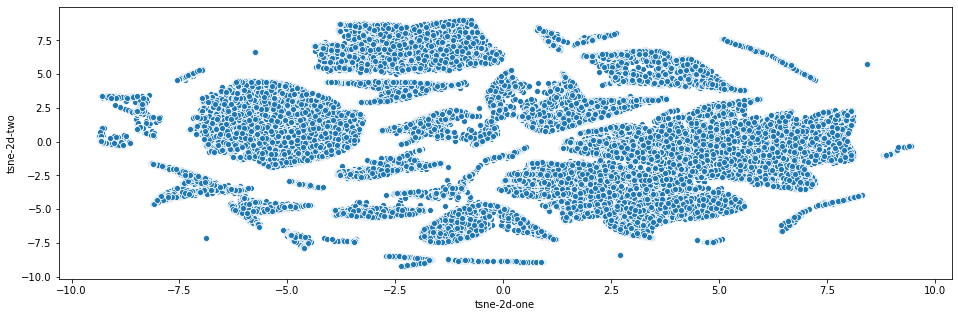

In [6]:
fig, axs = plt.subplots(figsize=(16,5))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=datos,
    legend="full"
)

# Clusterización

Calculamos el vecino más cercano de los datos. El punto de máxima curvatura es el EPS óptimo para clusterizar por DBSCAN.

In [7]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(exploratory)
distances, indices = nbrs.kneighbors(exploratory)

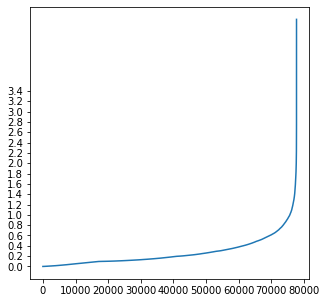

In [8]:
plt.figure(figsize=(5,5))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.yticks(np.arange(0, 3.5, 0.2));

In [9]:
c = DBSCAN(eps=1, min_samples=5)
c.fit(exploratory)
clusters = c.labels_

Aquí probamos si funcionó. Efectivamente, parece que funciona. Adicionalmente, como DBSCAN elige taaaantos clusters, decidimos quedarnos con todos los que tienen más de mil observaciones, es decir, con 22 clusters (*recordemos que el cluster -1 es el ruido que no pudo ser clusterizado*).

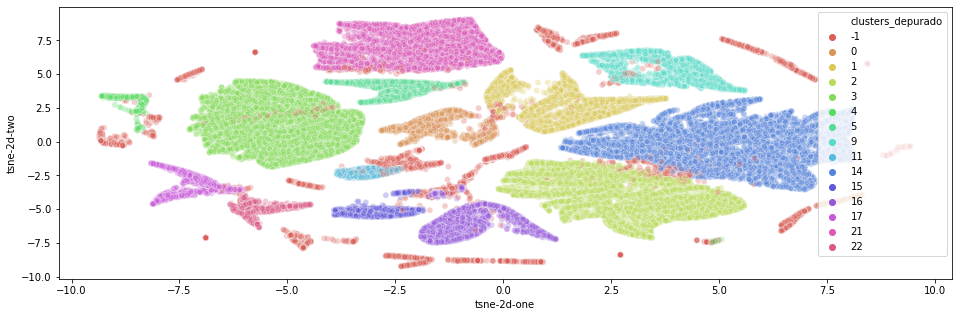

In [10]:
datos['clusters'] = pd.DataFrame(clusters)[0]
clusters_relevantes = datos['clusters'].isin(datos['clusters'].value_counts()[datos['clusters'].value_counts() > 1000].index)
datos['clusters_depurado'] = datos['clusters']
datos.loc[~clusters_relevantes, 'clusters_depurado'] = -1
fig, axs = plt.subplots(figsize=(16,5))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="clusters_depurado",
    palette=sns.color_palette("hls", len(datos['clusters_depurado'].unique())),
    data=datos,
    legend="full",
    alpha=0.3
)

# Modelo perfecto

Con el resultado anterior, entrenamos un Naive Bayes sin tener en cuenta las observaciones que algoritmo detectó como ruido. Esto nos permitirá asignar el ruido a alguno de los cluster.

In [11]:
X = df_cluster
y = datos['clusters_depurado']

In [12]:
X_nonoise = X[y != -1].copy()
y_nonoise = y[y != -1].copy()

Como es de esperar obtenemos un muy buen modelo

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, cohen_kappa_score

X_train, X_test, y_train, y_test = train_test_split(X_nonoise, y_nonoise, test_size=0.8)
nb = GaussianNB()
y_pred = nb.fit(X_train, y_train).predict(X_test)

acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.9993955147192166
Kappa: 0.9993237954868498



In [14]:
y_paint = nb.predict(X)
datos['cluster_predict'] = y_paint

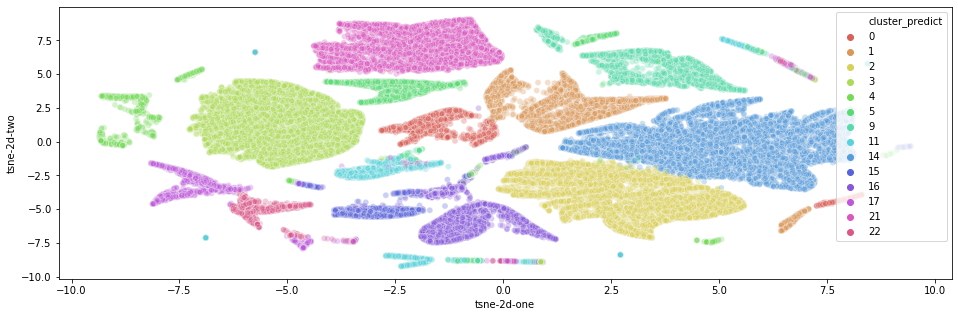

In [15]:
fig, axs = plt.subplots(figsize=(16,5))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster_predict",
    palette=sns.color_palette("hls", len(datos['cluster_predict'].unique())),
    data=datos,
    legend="full",
    alpha=0.3
)

Para entender un poco el modelo vemos la importancia de las variables. Al parecer estar en la carcel y el nivel educativo, así como la cantidad de reincidencias, son variables muy importantes.

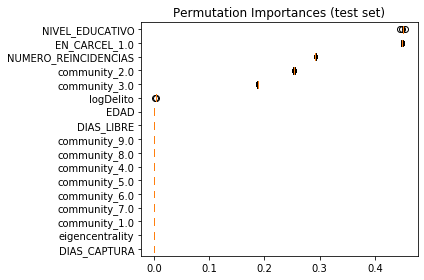

In [16]:
result = permutation_importance(nb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


# Baseline

Sin embargo, estas comunidades, este log de la frecuencia de delitos, la centralidad... son variables poco interpretables. Intentemos usar variables más habituales para el futuro usuario.

In [17]:
X1 = pd.get_dummies(df.TITULO_DELITO, drop_first=True)
X1 = pd.concat([X1, df[['INTERNOEN', 'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE', 'NUMERO_REINCIDENCIAS', 'EN_CARCEL']]], axis = 1)
X1 = X1.groupby(cuantitativas[0]).mean()
X1.reset_index(drop = True, inplace = True)
X1.fillna(0, inplace = True)

In [18]:
X1_nonoise = X1[y != -1].copy()
y1_nonoise = y[y != -1].copy()

Este modelo es el que tenemos que mejorar...

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, cohen_kappa_score

X1_train, X1_test, y1_train, y1_test = train_test_split(X1_nonoise, y1_nonoise, test_size=0.2)
nba = GaussianNB()
y1_pred = nba.fit(X1_train, y1_train).predict(X1_test)

acc = accuracy_score(y1_test, y1_pred)
kappa = cohen_kappa_score(y1_test, y1_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.9475338491295938
Kappa: 0.9413420672780464



In [20]:
y1_paint = nba.predict(X1)
datos['cluster_predict'] = y1_paint

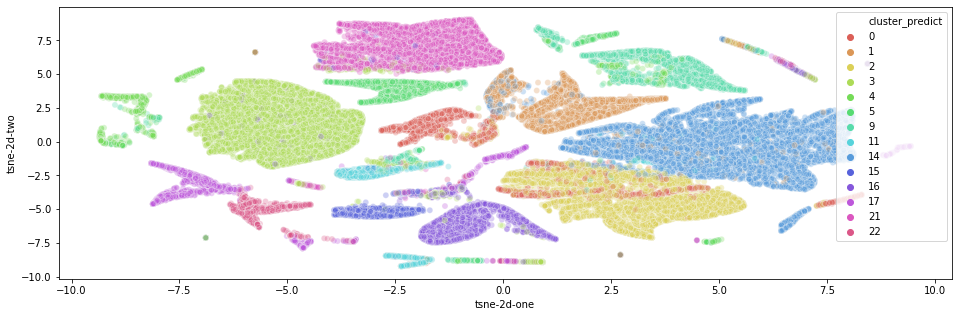

In [21]:
fig, axs = plt.subplots(figsize=(16,5))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster_predict",
    palette=sns.color_palette("hls", len(datos['cluster_predict'].unique())),
    data=datos,
    legend="full",
    alpha=0.3
)

# Random forest

El random forest lo hace mejor

In [22]:
rf = RandomForestClassifier(random_state = 16)
y1_pred = rf.fit(X1_train, y1_train).predict(X1_test)

acc = accuracy_score(y1_test, y1_pred)
kappa = cohen_kappa_score(y1_test, y1_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.9664732430689877
Kappa: 0.9624552259340555



Hacemos tunning, empezamos con un random search...

In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X1_train, y1_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=16),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, verbose=2)

In [24]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [25]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 16)
base_model.fit(X1_train, y1_train)
base_accuracy = evaluate(base_model, X1_test, y1_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X1_test, y1_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.96%.
Model Performance
Accuracy = 0.97%.
Improvement of 0.40%.


Seguimos con un search grid cerca de los valores aleatorios

In [26]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': [4, 5, 6],
    'min_samples_leaf': [1],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [350, 400, 450]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X1_train, y1_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 17.7min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=16), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 30],
                         'max_features': [4, 5, 6], 'min_samples_leaf': [1],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [350, 400, 450]},
             verbose=2)

In [27]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X1_test, y1_test)

print('Improvement of {:0.2f}%.'.format(100*(grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.97%.
Improvement of 0.41%.


In [28]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 450}

# XGBoost

Comparamos el random forest afinado con un XGBoost

In [29]:
xgb = XGBClassifier(objective = 'multi:softmax')

y1_pred = xgb.fit(X1_train, y1_train).predict(X1_test)

acc = accuracy_score(y1_test, y1_pred)
kappa = cohen_kappa_score(y1_test, y1_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.9680851063829787
Kappa: 0.9642528686303063



In [366]:
xgb = XGBClassifier(learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='multi:softmax', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

y1_pred = xgb.fit(X1_train, y1_train).predict(X1_test)

acc = accuracy_score(y1_test, y1_pred)
kappa = cohen_kappa_score(y1_test, y1_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.9320669671603349
Kappa: 0.9270486244709587



# Modelo final

El mejor modelo es el random forest afinado, después de hacer un search grid.

In [30]:
modelo_segmentacion = RandomForestClassifier(random_state = 16, 
                                             bootstrap = True,
                                             max_depth = 20,
                                             max_features = 4,
                                             min_samples_leaf = 1,
                                             min_samples_split = 8,
                                             n_estimators = 450)

modelo_segmentacion.fit(X1_train, y1_train)

datos['cluster_predict'] = modelo_segmentacion.predict(X1)

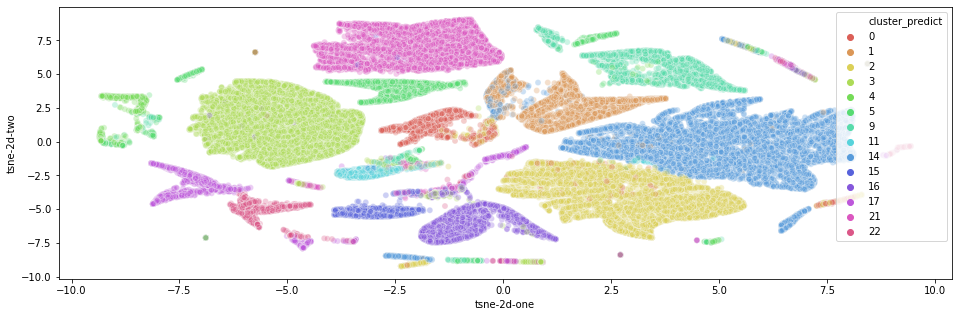

In [31]:
fig, axs = plt.subplots(figsize=(16,5))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster_predict",
    palette=sns.color_palette("hls", len(datos['cluster_predict'].unique())),
    data=datos,
    legend="full",
    alpha=0.3
)

Vemos que hay algunas variables poco importantes, y que podríamos eliminar.

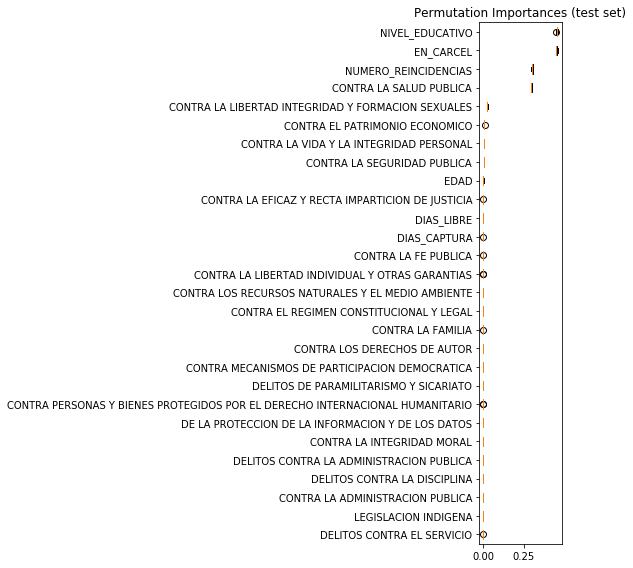

In [32]:
result = permutation_importance(modelo_segmentacion, X1_test, y1_test, n_repeats=10,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (8, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X1_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Explore clusters

Además vemos que hay muchos cluster. Reducimos la cantidad de clusters con un clustering jerárquico. Usamos una distancia promedio para decidir cuándo separar.

In [75]:
def pattern(column):
    results = pd.concat([X1, datos['cluster_predict']], axis = 1).groupby('cluster_predict')[column].mean().sort_values(ascending = False)
    
    return results

res = pd.DataFrame(map(pattern, X1.columns)).T

Tomamos los promedios de todas las variables de clusterización, por cluster.

In [114]:
pd.options.display.max_columns = 100
res

,CONTRA EL PATRIMONIO ECONOMICO,CONTRA EL REGIMEN CONSTITUCIONAL Y LEGAL,CONTRA LA ADMINISTRACION PUBLICA,CONTRA LA EFICAZ Y RECTA IMPARTICION DE JUSTICIA,CONTRA LA FAMILIA,CONTRA LA FE PUBLICA,CONTRA LA INTEGRIDAD MORAL,CONTRA LA LIBERTAD INDIVIDUAL Y OTRAS GARANTIAS,CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES,CONTRA LA SALUD PUBLICA,CONTRA LA SEGURIDAD PUBLICA,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,CONTRA LOS DERECHOS DE AUTOR,CONTRA LOS RECURSOS NATURALES Y EL MEDIO AMBIENTE,CONTRA MECANISMOS DE PARTICIPACION DEMOCRATICA,CONTRA PERSONAS Y BIENES PROTEGIDOS POR EL DERECHO INTERNACIONAL HUMANITARIO,DE LA PROTECCION DE LA INFORMACION Y DE LOS DATOS,DELITOS CONTRA EL SERVICIO,DELITOS CONTRA LA ADMINISTRACION PUBLICA,DELITOS CONTRA LA DISCIPLINA,DELITOS DE PARAMILITARISMO Y SICARIATO,LEGISLACION INDIGENA,EDAD,NIVEL_EDUCATIVO,DIAS_CAPTURA,DIAS_LIBRE,NUMERO_REINCIDENCIAS,EN_CARCEL
cluster_predict,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.020095,0.000142,0.001804,0.002536,0.000902,0.010897,0.000000,0.012265,0.000665,0.709786,0.235508,0.003879,0.000000,0.000855,0.000000,0.000000,0.000000,0.000142,0.000000,0.000000,0.000000,0.000000,37.384330,10.200000,1785.700571,836.651715,1.000000,1.000000
1,0.019984,0.000060,0.003649,0.001121,0.000678,0.022449,0.000000,0.010804,0.000350,0.823239,0.110457,0.005067,0.000000,0.000723,0.000000,0.000000,0.000105,0.000000,0.000060,0.000000,0.000000,0.000000,40.967725,3.656805,1890.093815,940.628072,1.000000,1.000000
2,0.480691,0.003193,0.007719,0.023998,0.028437,0.007094,0.000307,0.024104,0.025452,0.003929,0.246305,0.139476,0.000529,0.000719,0.000000,0.000846,0.001091,0.001045,0.000000,0.000000,0.000041,0.000116,34.582622,10.166733,1981.418908,822.028075,1.000000,1.000000
3,0.444087,0.005150,0.015096,0.042667,0.027713,0.005790,0.000266,0.013237,0.007983,0.005060,0.324546,0.098447,0.000320,0.000249,0.000000,0.000284,0.004399,0.000728,0.000053,0.000053,0.000053,0.000000,37.336921,3.926798,2016.150668,841.711020,1.000000,0.000000
4,0.026231,0.000166,0.002818,0.003066,0.001948,0.001160,0.000000,0.006315,0.000124,0.737187,0.218689,0.000622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000099,40.259572,3.526604,1366.864878,597.856872,2.156141,1.000000
5,0.555880,0.000410,0.004866,0.015513,0.029501,0.005788,0.000205,0.010548,0.007849,0.160162,0.161138,0.045786,0.000000,0.000410,0.000000,0.000205,0.000665,0.000239,0.000000,0.000000,0.000068,0.000000,34.565315,10.053235,1297.845777,561.083801,2.225225,1.000000
9,0.688232,0.001104,0.004267,0.020127,0.037148,0.007967,0.000387,0.011439,0.013862,0.001380,0.142973,0.065451,0.000000,0.000516,0.000000,0.000823,0.002437,0.001275,0.000000,0.000000,0.000000,0.000097,36.308095,3.743997,1327.428715,613.229916,2.268590,1.000000
11,0.014151,0.000000,0.000286,0.000858,0.018658,0.001334,0.000000,0.003002,0.949276,0.003478,0.001048,0.007623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000286,0.000000,0.000000,0.000000,0.000000,49.181818,4.746712,2313.997192,519.523556,1.004574,0.982276
14,0.430238,0.007628,0.006510,0.024952,0.029759,0.005170,0.000264,0.030183,0.001403,0.004311,0.292051,0.154954,0.000132,0.001791,0.000033,0.002320,0.001163,0.001838,0.000000,0.000044,0.000093,0.000016,37.449242,3.800132,2068.849390,905.470220,1.000000,1.000000


Usamos esos promedios para clusterizar y graficamos el dendograma. Con éste decidimos hacer siete clusters.

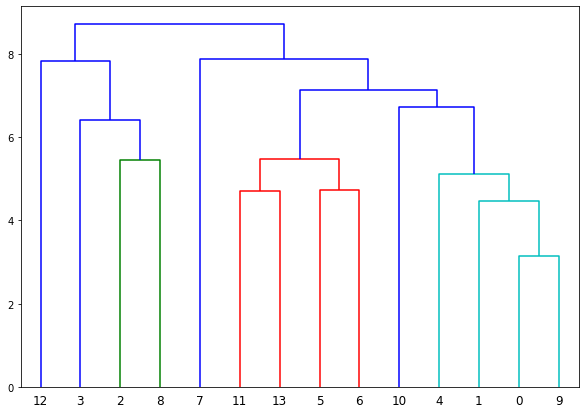

In [117]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

linked = linkage(scaler.fit_transform(res), 'average')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Mapeamos alguno de los 22 cluster a uno de los siete obtenidos con este método

In [136]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
cluster.fit_predict(scaler.fit_transform(res))

mapping = pd.DataFrame([res.index, cluster.labels_], index = ['tsne', 'hclust']).T
dict_mapping = mapping.set_index('tsne').to_dict()['hclust']

# Reducing clusters

Luego, con los 7 clusters (en lugar de los 22) y con menos variables volvemos a entrenar el random forest óptimo

In [185]:
modelo_segmentacion = RandomForestClassifier(random_state = 16, 
                                             bootstrap = True,
                                             max_depth = 20,
                                             max_features = 4,
                                             min_samples_leaf = 1,
                                             min_samples_split = 8,
                                             n_estimators = 450)

modelo_segmentacion.fit(X1_train[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']], y1_train.apply(lambda x: dict_mapping[x]))

datos['cluster_predict'] = modelo_segmentacion.predict(X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']])

Obtenemos un muy buen resultado en el conjunto de testeo

In [186]:
y1_pred = modelo_segmentacion.predict(X1_test[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']])

acc = accuracy_score(y1_test.apply(lambda x: dict_mapping[x]), y1_pred)
kappa = cohen_kappa_score(y1_test.apply(lambda x: dict_mapping[x]), y1_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.9612346872985171
Kappa: 0.9507728335729841



Y pareciera que clusteriza bien en el espacio encontrado por t-SNE

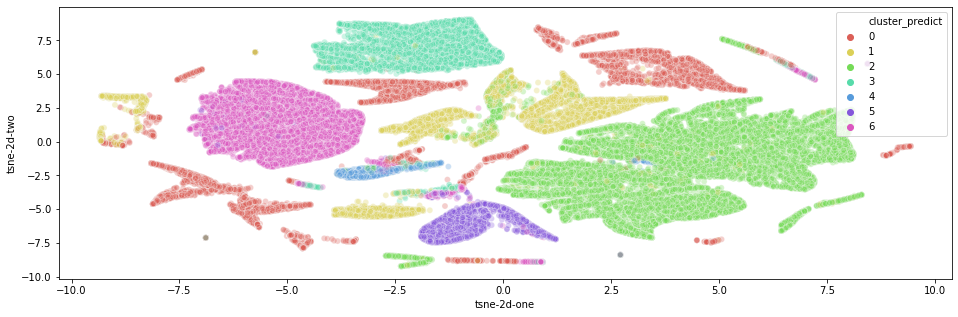

In [187]:
fig, axs = plt.subplots(figsize=(16,5))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster_predict",
    palette=sns.color_palette("hls", len(datos['cluster_predict'].unique())),
    data=datos,
    legend="full",
    alpha=0.3
)

Todas las variables, además, parecieran ser algo importantes...

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


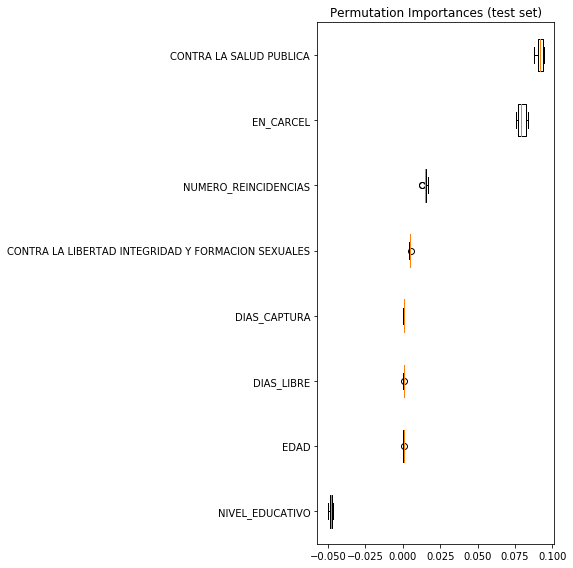

In [188]:
result = permutation_importance(modelo_segmentacion, X1_test[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']], y1_test, n_repeats=10,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (8, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X1_test[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Finalmente, para estudiar un poco cómo funcionan estos cluster, decidimos ver cómo las variables van afectando la probabilidad de pertenecer a un cluster u otro. Esto lo hacemos calculando la probabilidad promedio de pertenecer a cada cluster (de 5000 individuos aleatorios) cambiándoles solamente la variable que queremos estudiar. En el fondo, lo que estamos haciendo es una implementación algo cruda de un plot de dependencia parcial para Random Forest.

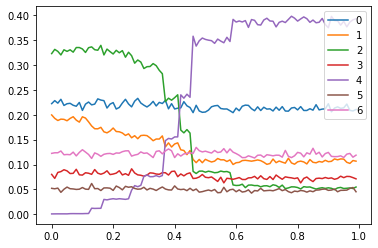

In [458]:
contra_libertad = {}
for i in np.arange(0, 1, 0.01):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES'] = i
    
    contra_libertad[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(contra_libertad, orient = 'index').plot()

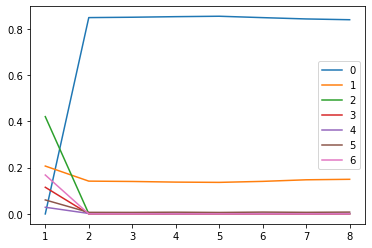

In [457]:
reincidencias = {}
for i in np.arange(1, 9, 1):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['NUMERO_REINCIDENCIAS'] = i
    
    reincidencias[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(reincidencias, orient = 'index').plot()

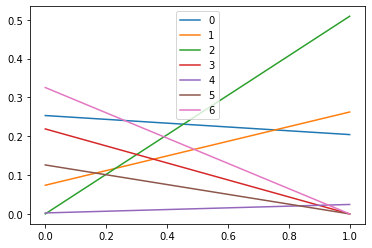

In [454]:
carcel = {}
for i in [0, 1]:
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['EN_CARCEL'] = i
    
    carcel[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(carcel, orient = 'index').plot()

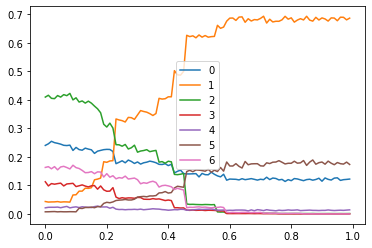

In [455]:
contra_salud = {}
for i in np.arange(0, 1, 0.01):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['CONTRA LA SALUD PUBLICA'] = i
    
    contra_salud[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(contra_salud, orient = 'index').plot()

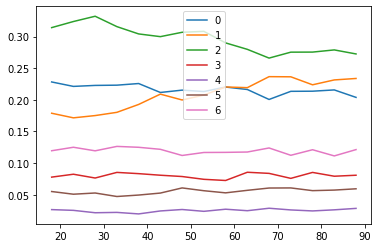

In [456]:
edad = {}
for i in np.arange(18, 90, 5):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['EDAD'] = i
    
    edad[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(edad, orient = 'index').plot()

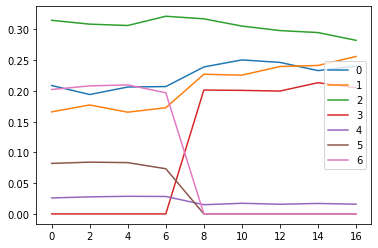

In [460]:
educ = {}
for i in np.arange(0, 18, 2):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['NIVEL_EDUCATIVO'] = i
    
    educ[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(educ, orient = 'index').plot()

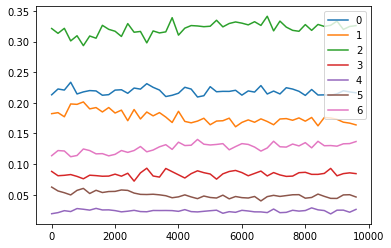

In [461]:
captura = {}
for i in np.arange(0, 9700, 200):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['DIAS_CAPTURA'] = i
    
    captura[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(captura, orient = 'index').plot()

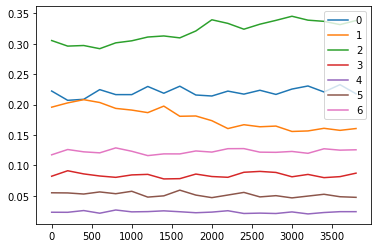

In [462]:
libre = {}
for i in np.arange(0, 3900, 200):
    proof = X1[['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
       'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
        'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']].sample(5000).copy()
    proof['DIAS_LIBRE'] = i
    
    libre[i] = np.mean(prueba.predict_proba(proof), axis = 0)

    
pd.DataFrame.from_dict(libre, orient = 'index').plot()

Adicionalmente, estudiamos cómo el promedio de otras variables varía por cluster.

In [535]:
resto = X1.copy()
resto['cluster'] = datos['cluster_predict'].copy()
resto.groupby('cluster').mean()

,CONTRA EL PATRIMONIO ECONOMICO,CONTRA EL REGIMEN CONSTITUCIONAL Y LEGAL,CONTRA LA ADMINISTRACION PUBLICA,CONTRA LA EFICAZ Y RECTA IMPARTICION DE JUSTICIA,CONTRA LA FAMILIA,CONTRA LA FE PUBLICA,CONTRA LA INTEGRIDAD MORAL,CONTRA LA LIBERTAD INDIVIDUAL Y OTRAS GARANTIAS,CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES,CONTRA LA SALUD PUBLICA,CONTRA LA SEGURIDAD PUBLICA,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,CONTRA LOS DERECHOS DE AUTOR,CONTRA LOS RECURSOS NATURALES Y EL MEDIO AMBIENTE,CONTRA MECANISMOS DE PARTICIPACION DEMOCRATICA,CONTRA PERSONAS Y BIENES PROTEGIDOS POR EL DERECHO INTERNACIONAL HUMANITARIO,DE LA PROTECCION DE LA INFORMACION Y DE LOS DATOS,DELITOS CONTRA EL SERVICIO,DELITOS CONTRA LA ADMINISTRACION PUBLICA,DELITOS CONTRA LA DISCIPLINA,DELITOS DE PARAMILITARISMO Y SICARIATO,LEGISLACION INDIGENA,EDAD,NIVEL_EDUCATIVO,DIAS_CAPTURA,DIAS_LIBRE,NUMERO_REINCIDENCIAS,EN_CARCEL
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.582037,0.000690,0.006900,0.021986,0.026985,0.010293,0.000194,0.008474,0.006918,0.127330,0.160069,0.042831,0.000055,0.001146,0.000000,0.000291,0.002238,0.000624,0.000000,0.000028,0.000018,0.000039,35.849720,6.610714,1325.105336,606.520821,2.224588,0.570787
1,0.021613,0.000259,0.003760,0.003568,0.001149,0.001802,0.000082,0.006205,0.000276,0.843188,0.110630,0.005702,0.000027,0.000082,0.000000,0.000020,0.000000,0.000232,0.000027,0.000000,0.000000,0.000000,39.231676,6.340676,1804.909499,864.185301,1.168537,0.844976
2,0.445450,0.005717,0.006460,0.023702,0.028787,0.011530,0.000219,0.028854,0.001233,0.003041,0.287488,0.146330,0.000274,0.001585,0.000020,0.001703,0.001146,0.001433,0.000000,0.000026,0.000072,0.000049,36.325353,6.331661,2020.060895,874.832850,1.000000,1.000000
3,0.480252,0.002051,0.026326,0.042310,0.020146,0.028240,0.000228,0.010316,0.005710,0.001973,0.285218,0.080399,0.000874,0.002018,0.000177,0.000076,0.003064,0.002031,0.000000,0.000000,0.000000,0.000000,35.470222,10.515497,2003.213858,875.529029,1.000000,0.000000
4,0.018170,0.000000,0.000672,0.000756,0.015936,0.001343,0.000252,0.004198,0.942930,0.003610,0.002561,0.009236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000252,0.000000,0.000000,0.000000,0.000084,47.357683,5.567758,2351.180453,511.826451,1.000000,1.000000
5,0.015307,0.000000,0.002298,0.004408,0.001079,0.000938,0.000000,0.001055,0.000422,0.919768,0.048071,0.003212,0.000094,0.000703,0.000000,0.000000,0.000211,0.000000,0.000000,0.000000,0.000000,0.000000,40.756331,3.672763,2012.275599,917.829712,1.000000,0.000000
6,0.425299,0.004898,0.016139,0.042482,0.026528,0.028117,0.000304,0.012979,0.010650,0.004455,0.314203,0.093393,0.000304,0.007517,0.000000,0.000270,0.004942,0.000693,0.000051,0.000051,0.000051,0.000000,37.859025,3.941320,2009.830868,838.129456,1.000000,0.000000


# Save model

Con las investigaciones pasadas, ya podemos salvar el modelo en un pickle

In [7]:
nombre_modelo = 'modelo_segmentacion.pkl'
#joblib.dump(modelo_segmentacion, nombre_modelo)

In [9]:
prueba = joblib.load(nombre_modelo)

a = pd.DataFrame([0.4, 2, 0, 0.6, 25, 5, 2000, 2220]).T
a.columns = ['CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES',
             'NUMERO_REINCIDENCIAS', 'EN_CARCEL', 'CONTRA LA SALUD PUBLICA',
             'EDAD', 'NIVEL_EDUCATIVO', 'DIAS_CAPTURA', 'DIAS_LIBRE']
prueba.predict(a)

array([0], dtype=int64)

Y definir cada uno de los clúster de la siguiente forma:

- 0: Interno con alta probabilidad de reincidir varias veces
- 1: Interno con alta probabilidad de no estar en prisión domiciliaria y de estar sindicado de delitos contra la salud pública
- 2: Interno con baja probabilidad de estar sindicado de cometer delitos contra la libertad, integridad y formación sexual, con baja probabilidad de reincidir más de una vez, con alta probabilidad de no estar en prisión domiciliaria y con baja probabilidad de estar sindicado de delitos contra la salud pública
- 3: Interno con alta probabilidad de estar en prisión domiciliaria y con alto nivel educativo
- 4: Interno con alta probabilidad de estar sindicado de cometer delitos contra la libertad, integridad y formación sexual, pero baja probabilidad de estar sindicado de cometer delitos contra la seguridad pública y contra el patrimonio económico. Muy baja probabilidad de estar sindicado de cometer delitos contra los derechos de autor y contra los recursos naturales y el medio ambiente. Este interno es el perfil que, en promedio, pasa menos días libre, antes de reincidir de nuevo.
- 5: Interno con alta probabilidad de estar en prisión domiciliaria y de estar sindicado de cometer delitos contra la salud pública pero baja probabilidad de estar sindicado de delitos contra el patrimonio económico. Este interno es el perfil que, en promedio, pasa más días libre, antes de reincidir de nuevo.
- 6: Interno con alta probabilidad de estar en prisión domiciliaria y con bajo nivel educativo.

# Prueba

Por último, nos conectamos a la base de datos y probamos nuestro modelo.

In [3]:
import pyodbc 
from sqlalchemy import create_engine

server = 'whiskas.database.windows.net' 
database = 'dbminjusticia' 
username = 'whiskasadmin' 
password = 'Ds4All2020*' 
sql_conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

def runQuery(sql):
    _df = pd.read_sql(sql, sql_conn)
    return _df

In [10]:
df_segmentar = runQuery("""
WITH info_general_interno AS(
    SELECT
        persona.PersonId,
        MAX(persona.RemoteId) INTERNOEN,
        AVG(YEAR(GETDATE()) - persona.YearBorn) EDAD,
        MAX(CASE educ.Name
            WHEN 'ANALFABETA' THEN 0
            WHEN 'CICLO I' THEN 2
            WHEN 'CICLO II' THEN 5
            WHEN 'CICLO III' THEN 9
            WHEN 'CICLO IV' THEN 11
            WHEN 'TECNICO' THEN 13
            WHEN 'TECNOLOGICO' THEN 14
            WHEN 'PROFESIONAL' THEN 16
            WHEN 'MAGISTER' THEN 18
            WHEN 'POST GRADO' THEN 18
            ELSE 0
        END) NIVEL_EDUCATIVO,
        AVG(CASE grupo.[Group]
            WHEN 'CONTRA LA LIBERTAD INTEGRIDAD Y FORMACION SEXUALES'
                THEN 1
            ELSE 0
        END) CONTRA_LIBERTAD,
        AVG(CASE grupo.[Group]
            WHEN 'CONTRA LA SALUD PUBLICA'
                THEN 1
            ELSE 0
        END) CONTRA_SALUD,
        AVG(CASE
            WHEN (reclusionstatus.Name = 'Espera Traslado' OR reclusionstatus.Name = 'Intramuros')
                THEN 1
            ELSE 0
        END) EN_CARCEL
    FROM
        dbo.Person persona
    LEFT JOIN 
        dbo.Scholarship educ
        ON
        persona.ScholarshipId = educ.ScholarshipId
    LEFT JOIN
        dbo.Reclusion reclusion
        ON persona.PersonId = reclusion.PersonId
    LEFT JOIN 
        dbo.ReclusionStatus reclusionstatus
        ON reclusion.ReclusionStatusId = reclusionstatus.ReclusionStatusId
    LEFT JOIN
        dbo.Crime crimen
        ON crimen.CrimeId = reclusion.CrimeId
    LEFT JOIN
        dbo.CrimeGroup grupo
        ON grupo.GroupId = crimen.GroupId
    GROUP BY persona.PersonId),
    
    
    
reincidencias_interno AS(
    SELECT
        PersonId, COUNT(*) NUMERO_REINCIDENCIAS
    FROM (
        SELECT 
            PersonId, StartDate
        FROM 
            dbo.Reclusion
        GROUP BY PersonId, StartDate) reincidencias
    GROUP BY PersonId),
    
    

    dias_captura AS (
        SELECT
            PersonId, DATEDIFF(day, LAG(CaptureDate, 1) OVER(PARTITION BY PersonId ORDER BY CaptureDate), CaptureDate) DIAS_CAPTURA
        FROM 
            (SELECT 
                PersonId, CaptureDate 
            FROM 
                dbo.Reclusion 
            GROUP BY 
                PersonId, CaptureDate) captura
        ),
dias_captura_interno AS (
    SELECT
        PersonId, 
        AVG(
        CASE 
            WHEN DIAS_CAPTURA IS NULL THEN 0
            ELSE DIAS_CAPTURA
        END) DIAS_CAPTURA
    FROM 
        dias_captura
    GROUP BY PersonId),
    
    

    dias_libre AS (
        SELECT
        PersonId, 
        StartDate,
        DATEDIFF(day, LAG(StartDate, 1) OVER(PARTITION BY PersonId ORDER BY StartDate), StartDate) DIAS_INICIO, 
        LAG(DATEDIFF(day, StartDate, EndDate), 1) OVER(PARTITION BY PersonId ORDER BY StartDate) DIAS_CONDENA
    FROM 
        (SELECT 
            PersonId, StartDate, EndDate
        FROM 
            dbo.Reclusion 
        GROUP BY 
            PersonId, StartDate, EndDate) libre
    ),
dias_libre_interno AS(
    SELECT 
        PersonId, 
        AVG(CASE
            WHEN DIAS_INICIO - DIAS_CONDENA IS NULL
                THEN 0
            ELSE DIAS_INICIO - DIAS_CONDENA
        END) DIAS_LIBRE
    FROM (
        SELECT PersonId,
            CASE 
                WHEN DIAS_INICIO IS NULL THEN 0
                WHEN DIAS_INICIO < 0 THEN 0
                ELSE DIAS_INICIO
            END DIAS_INICIO,
            CASE
                WHEN DIAS_CONDENA IS NULL THEN 0
                ELSE ABS(DIAS_CONDENA)
            END DIAS_CONDENA
        FROM 
            dias_libre) DIAS_CONDENA_INICIO
    GROUP BY PersonId)
    
SELECT 
    info_general_interno.PersonId, 
    INTERNOEN, CONTRA_LIBERTAD,
    NUMERO_REINCIDENCIAS, EN_CARCEL, CONTRA_SALUD,
    EDAD, NIVEL_EDUCATIVO, DIAS_CAPTURA, DIAS_LIBRE
FROM info_general_interno
LEFT JOIN
    dias_libre_interno
    ON info_general_interno.PersonId = dias_libre_interno.PersonId
LEFT JOIN
    dias_captura_interno
    ON info_general_interno.PersonId = dias_captura_interno.PersonId
LEFT JOIN
    reincidencias_interno
    ON info_general_interno.PersonId = reincidencias_interno.PersonId
    """)

In [19]:
descripcion = {}
descripcion[0] = "Interno con alta probabilidad de reincidir varias veces."
descripcion[1] = "Interno con alta probabilidad de no estar en prisión domiciliaria y de estar sindicado de delitos contra la salud pública."
descripcion[2] = "Interno con baja probabilidad de estar sindicado de cometer delitos contra la libertad, integridad y formación sexual, con baja probabilidad de reincidir más de una vez, con alta probabilidad de no estar en prisión domiciliaria y con baja probabilidad de estar sindicado de delitos contra la salud pública."
descripcion[3] = "Interno con alta probabilidad de estar en prisión domiciliaria y con alto nivel educativo."
descripcion[4] = "Interno con alta probabilidad de estar sindicado de cometer delitos contra la libertad, integridad y formación sexual, pero baja probabilidad de estar sindicado de cometer delitos contra la seguridad pública y contra el patrimonio económico. Muy baja probabilidad de estar sindicado de cometer delitos contra los derechos de autor y contra los recursos naturales y el medio ambiente. Este interno es el perfil que, en promedio, pasa menos días libre, antes de reincidir de nuevo."
descripcion[5] = "Interno con alta probabilidad de estar en prisión domiciliaria y de estar sindicado de cometer delitos contra la salud pública pero baja probabilidad de estar sindicado de delitos contra el patrimonio económico. Este interno es el perfil que, en promedio, pasa más días libre, antes de reincidir de nuevo."
descripcion[6] = "Interno con alta probabilidad de estar en prisión domiciliaria y con bajo nivel educativo."

In [12]:
y = prueba.predict(df_segmentar.iloc[:,2:])

In [13]:
descripcion[y[16]]